In [1]:
import os
import subprocess
import time
import pickle

import numpy as np

import cv2

from matplotlib import pyplot as plt

import random
%matplotlib inline

In [100]:
class Env:
    def __init__(self):
        self.restart_btn_img = cv2.imread('./restart_button.png', cv2.IMREAD_GRAYSCALE)
        self.action_space = range(20)
        self.dist_space = np.linspace(300, 1000, len(self.action_space))
    
    def __jump(self, distance):
        subprocess.call(".\\adb\\adb shell input swipe 500 500 500 500 %d" % distance)
        time.sleep(distance / 1000 + 2)
        
        
    def __capture_img(self, filename):
        subprocess.call('.\\adb\\adb shell /system/bin/screencap -p /sdcard/screenshot.png')
        time.sleep(0.1)
        subprocess.call('.\\adb\\adb pull /sdcard/screenshot.png %s' % filename)
        time.sleep(0.1)

        
    def __find_restart_btn(self, screen_shot_im):
        result = cv2.matchTemplate(screen_shot_im,
                                   self.restart_btn_img,
                                   cv2.TM_CCOEFF_NORMED)
        if result.max() > 0.8:
            y,x = np.unravel_index(result.argmax(),result.shape)
            y += self.restart_btn_img.shape[0] // 2
            x += self.restart_btn_img.shape[1] // 2
            return x, y
        else:
            return -1, -1
        
    def __to_state(self, screen_shot_im):
        return np.expand_dims(cv2.resize(screen_shot_im, (120, 200)) / 255.0,-1)
    
    
    def dist(self,action):
        if action >= 0 and action < len(self.action_space):
            return self.dist_space[action]
        
        
    def reset(self):
        self.__capture_img('./tmp/screenshot.png')
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        btn_x, btn_y = self.__find_restart_btn(im)
        
        # The game has not ended yet
        if btn_x == -1:
            # Kill self
            self.__jump(1500)
            self.__capture_img('./tmp/screenshot.png')
            im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
            btn_x, btn_y = self.__find_restart_btn(im)
            
            assert btn_x != -1
                
        subprocess.call('.\\adb\\adb shell input tap %d %d' % (btn_x, btn_y))
        time.sleep(0.5)

        self.__capture_img('./tmp/screenshot.png')
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        btn_x, btn_y = self.__find_restart_btn(im)

        assert btn_x == -1
        
        return self.__to_state(im)
        
        
    def step(self, action):
        '''
        action: touch time(milliseconds)
        return: 
        '''
        time.sleep(0.5)
        
        dist = self.dist(action)
        self.__jump(dist)
        
        self.__capture_img('./tmp/screenshot.png')
        
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        
        btn_x, btn_y = self.__find_restart_btn(im)
        
        # The game has not ended yet
        if btn_x == -1:
            state = self.__to_state(im)
            reward = 1
            done = False
            return state, reward, done
        else:
            state = None
            reward = -1
            done = True
            return state, reward, done
        

In [74]:
im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
np.shape(cv2.resize(im, (120, 200)) / 255.0)

(200, 120)

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17173860259303169744
]


In [4]:
from keras.layers import *
from keras.models import Model,load_model,Sequential
from keras.callbacks import *
from keras.optimizers import *
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.applications.resnet50 import identity_block, conv_block

Using TensorFlow backend.


In [107]:
# Deep-Q learning Agent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.memory = []
        
        if os.path.exists('./tmp/memory.m'):
            self.memory = pickle.load(open('./tmp/memory.m','rb'))
    
        self.gamma = 0.9  # decay rate
        self.epsilon = 1  # exploration
        self.epsilon_decay = .97
        self.epsilon_min = 0.01
        self.learning_rate = 0.0001
#         self.learning_rate = 0.01
        self._build_model()
        
        self.mem_len = 100
    
    def _build_model(self):
        inputs = Input(shape=(200,120,1))
        
        def Slice():
            def func(x):
                return x[:,50:170,:,:] - 0.5
            return Lambda(func)
        
        x = Slice()(inputs)
        
#         x = Conv2D(16, (5, 5), strides=(2, 2), padding='same', name='conv1')(x)
#         x = BatchNormalization()(x)
#         x = Activation('relu')(x)
#         x = MaxPooling2D((3, 3), strides=(2, 2))(x)

#         x = conv_block(x, 3, [32, 32, 32], stage=2, block='a', strides=(1, 1))
#         x = identity_block(x, 3, [32, 32, 32], stage=2, block='b')
        
#         x = conv_block(x, 3, [32, 32, 64], stage=3, block='a')
#         x = identity_block(x, 3, [64, 64, 64], stage=3, block='b')
#         x = identity_block(x, 3, [64, 64, 64], stage=3, block='c')
        
#         x = conv_block(x, 3, [32, 32, 8], stage=4, block='a', strides=(1, 1))
#         x = identity_block(x, 3, [8, 8, 8], stage=4, block='b')
#         x = identity_block(x, 3, [8, 8, 8], stage=4, block='c')

#         x = GlobalAveragePooling2D()(x)
#         x = Dense(128, activation='relu')(x)

        x = AveragePooling2D((3,3),strides=(2,2), padding='same')(x)

        x = Conv2D(16, (8, 8), strides=(4,4), padding='same')(x)
#         x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        x = Conv2D(32, (4, 4), strides=(2,2), padding='same')(x)
#         x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
#         x = Conv2D(8, (3, 3), padding='same')(x)
# #         x = BatchNormalization()(x)
#         x = Activation('relu')(x)
        
#         x = GlobalAveragePooling2D()(x)
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)

        outputs = Dense(len(self.env.action_space), activation='linear')(x)
        model = Model(inputs, outputs)
        model.compile(loss='mean_squared_error', optimizer=Nadam(lr=self.learning_rate))

        self.model = model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            print('random!')
            return random.sample(env.action_space,1)[0]
        act_values = self.model.predict_on_batch(np.expand_dims(state,0))
        return np.argmax(act_values[0])
        
    def replay(self, batch_size):
        mem = self.memory[-self.mem_len:]
        
        n_batch = min(batch_size, len(mem))
        batches = np.random.choice(len(mem), n_batch)
        
        loss = 0
        for i,mem_idx in enumerate(batches):
            state, action, reward, next_state, done = mem[mem_idx]
            # if done, make our target reward
            target = reward
            if not done:
              # predict the future discounted reward
              target = reward + self.gamma * \
                       np.amax(self.model.predict_on_batch(np.expand_dims(next_state,0))[0])
            # make the agent to approximately map
            # the current state to future discounted reward
            # We'll call that target_f
            target_f = self.model.predict_on_batch(np.expand_dims(state,0))
            target_f[0][action] = target
            # Train the Neural Net with the state and target_f
            loss += self.model.train_on_batch(np.expand_dims(state,0), target_f)
            
        loss /= n_batch
        return loss
    
    def save_weights(self):
        self.model.save_weights('./tmp/weights.w')
        
    def load_weights(self):
        self.model.load_weights('./tmp/weights.w')

In [108]:
episodes = 500

# 为agent初始化gym环境参数
env = Env()
agent = DQNAgent(env)

agent.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 200, 120, 1)       0         
_________________________________________________________________
lambda_12 (Lambda)           (None, 120, 120, 1)       0         
_________________________________________________________________
average_pooling2d_12 (Averag (None, 60, 60, 1)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 16)        1040      
_________________________________________________________________
activation_23 (Activation)   (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 32)          8224      
_________________________________________________________________
activation_24 (Activation)   (None, 8, 8, 32)          0         
__________

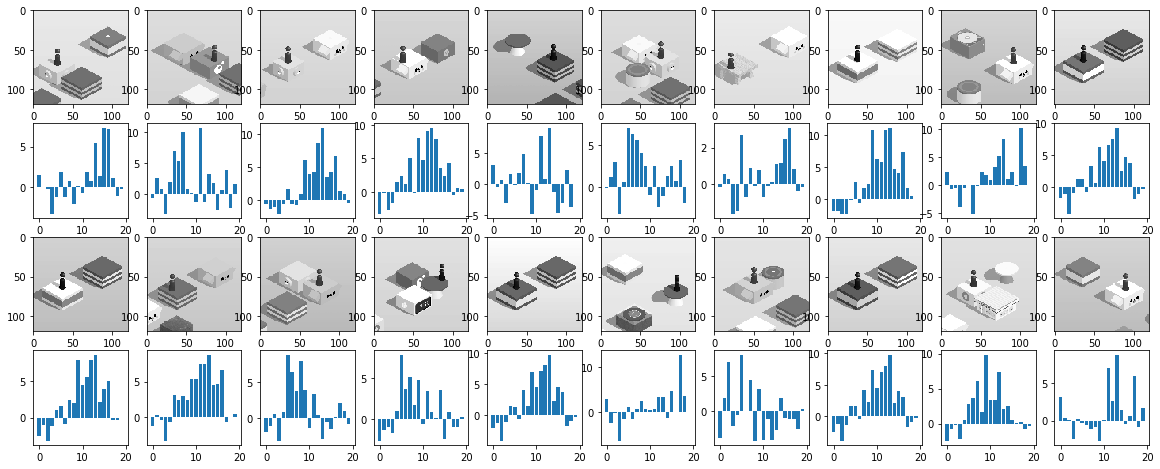

In [139]:
f, axes = plt.subplots(4,10,figsize=(20,8))

for i in range(4):
    for j in range(10):
        if i % 2 == 0:
            state = random.choice(agent.memory)[0]
            pic = state[50:170,:,0]
            axes[i][j].imshow(pic, cmap='gray')
        
            axes[i+1][j].bar(agent.env.action_space,agent.model.predict(np.expand_dims(state,0))[0])

In [141]:
scores = []

# 游戏的主循环
for e in range(episodes):

    # 在每次游戏开始时复位状态参数
    state = env.reset()

    # time_t 代表游戏的每一帧
    # time_t 越大，分数越高
    
    loss = 0
    for time_t in range(10000):
        
        # turn this on if you want to render
        # env.render()

        # 选择行为
        action = agent.act(state)

        # 在环境中施加行为推动游戏进行
        next_state, reward, done = env.step(action)
        
        print('jump dist:', env.dist(action))

        # 记忆先前的状态，行为，回报与下一个状态
        agent.remember(state, action, reward, next_state, done)

        # 使下一个状态成为下一帧的新状态
        state = copy.deepcopy(next_state)
        
        loss += agent.replay(32)

        # 如果游戏结束done被置为ture
        # 除非agent没有完成目标
        if done:
            # 打印分数并且跳出游戏循环
            print("episode: {}/{}, score: {}"
                  .format(e, episodes, time_t))
            scores.append(time_t)
            break
    
    loss /= (i+1)
    
    print('mem:', len(agent.memory), 'epsilon:', agent.epsilon, 'loss:', loss)
    
    if episodes % 10 == 0:
        agent.save_weights()
        
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

jump dist: 778.947368421
jump dist: 373.684210526
jump dist: 484.210526316
jump dist: 484.210526316
jump dist: 778.947368421
jump dist: 557.894736842
jump dist: 778.947368421
jump dist: 705.263157895
jump dist: 778.947368421
random!
jump dist: 484.210526316
episode: 0/500, score: 9
mem: 2605 epsilon: 0.009756714760036816 loss: 0.091402466808
jump dist: 778.947368421
jump dist: 778.947368421
episode: 1/500, score: 1
mem: 2607 epsilon: 0.009756714760036816 loss: 0.00688188071832
jump dist: 742.105263158
jump dist: 705.263157895
jump dist: 631.578947368
jump dist: 705.263157895
jump dist: 926.315789474
jump dist: 484.210526316
jump dist: 557.894736842
jump dist: 852.631578947
jump dist: 705.263157895
jump dist: 484.210526316
jump dist: 926.315789474
jump dist: 705.263157895
jump dist: 631.578947368
jump dist: 742.105263158
jump dist: 778.947368421
jump dist: 742.105263158
jump dist: 705.263157895
jump dist: 521.052631579
jump dist: 631.578947368
jump dist: 889.473684211
jump dist: 705.263

KeyboardInterrupt: 

In [70]:
agent.epsilon = 0.01

<Container object of 20 artists>

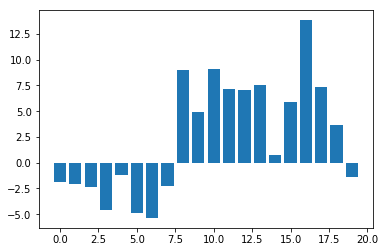

In [117]:
plt.bar(agent.env.action_space,agent.model.predict(np.expand_dims(agent.memory[][0],0))[0])

In [91]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(*args, **kwargs)
    Make a bar plot.
    
    Call signatures::
    
       bar(x, height, *, align='center', **kwargs)
       bar(x, height, width, *, align='center', **kwargs)
       bar(x, height, width, bottom, *, align='center', **kwargs)
    
    Make a bar plot with rectangles bounded by
    
    .. math::
    
       (x - width/2, x + width/2, bottom, bottom + height)
    
    (left, right, bottom and top edges) by default.  *x*,
    *height*, *width*, and *bottom* can be either scalars or
    sequences.
    
    The *align* and *orientation* kwargs control the interpretation of *x*
    and *bottom*
    
    The *align* keyword-only argument controls if *x* is interpreted
    as the center or the left edge of the rectangle.
    
    Parameters
    ----------
    x : sequence of scalars
        the x coordinates of the bars.
    
        *align* controls if *x* is the bar center (default) or
        left edge.
    
    heig

In [138]:
agent.model.save_weights('./tmp/weights.w')
pickle.dump(agent.memory, open('./tmp/memory.m','wb'))

In [68]:
min_loss = 1e10
min_pos = 0

for i in range(1000):
    loss = 0
    for i in range(50):
        l = agent.replay(32)
        loss += l
    print(loss / 50)
    
    if loss < min_loss:
        min_pos = i
        min_loss = loss
    
    if i - min_pos > 100:
        break

i

128.82689827
94.7225925446
37.4278962708
31.1282489967
15.9667807198
16.0796065235
14.0383515739
12.0921261883
11.2964262009
8.64634869099
7.35213395119
7.32252527714
6.3635424757
4.71984107256
4.57263987064
3.77086829185
4.77240906715
3.48491025209
9.52575344563
5.55766092539
4.55353834867
3.18393145323
2.79013663769
2.49263638139
3.06989862561
4.35556167364
2.88895393372
2.96023203969
3.11350908041
4.47541817427
3.99412070513


KeyboardInterrupt: 

In [58]:
i, min_pos

(228, 227)

In [178]:
agent.epsilon

0.20554993075174754